In [1]:
import torch

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

# Dataset path
dataset_path = "./data/train"

# Define transformations
transform = transforms.Compose([
    # transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Class labels
class_labels = full_dataset.classes
print(f"Class labels: {class_labels}")


Class labels: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Toma

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN model
class PlantDiseaseModel(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, padding=1, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, padding=1, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(64, 128, padding=1, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(128, 256, padding=1, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(256 * 16 * 16, 512)  # Adjust dimensions based on pooling
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 16 * 256)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [4]:
# Initialize the model
model = PlantDiseaseModel(num_classes=len(class_labels)).to(device)

In [5]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [6]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    min_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()

        print(f"Epoch {epoch + 1}/{num_epochs}:")

        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            print(f"Epoch {epoch + 1}/{num_epochs}::Validation:")
            for inputs, labels in tqdm(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total

        if val_loss < min_loss:
            min_loss = val_loss
            torch.save({"val_loss": val_loss, "val_acc": val_acc, "model_state": model.state_dict()}, "best_model.pt")

        # Save history
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=15
)


Epoch 1/15:


100%|██████████| 1758/1758 [04:15<00:00,  6.88it/s]


Epoch 1/15::Validation:


100%|██████████| 440/440 [00:32<00:00, 13.72it/s]


Epoch 1/15, Train Loss: 1.3925, Train Acc: 0.5912, Val Loss: 0.5456, Val Acc: 0.8389
Epoch 2/15:


100%|██████████| 1758/1758 [04:17<00:00,  6.82it/s]


Epoch 2/15::Validation:


100%|██████████| 440/440 [00:33<00:00, 13.26it/s]


Epoch 2/15, Train Loss: 0.6679, Train Acc: 0.7919, Val Loss: 0.3444, Val Acc: 0.8986
Epoch 3/15:


100%|██████████| 1758/1758 [04:16<00:00,  6.86it/s]


Epoch 3/15::Validation:


100%|██████████| 440/440 [00:33<00:00, 13.13it/s]


Epoch 3/15, Train Loss: 0.4626, Train Acc: 0.8553, Val Loss: 0.2559, Val Acc: 0.9198
Epoch 4/15:


100%|██████████| 1758/1758 [04:16<00:00,  6.86it/s]


Epoch 4/15::Validation:


100%|██████████| 440/440 [00:33<00:00, 13.16it/s]


Epoch 4/15, Train Loss: 0.3467, Train Acc: 0.8901, Val Loss: 0.1791, Val Acc: 0.9452
Epoch 5/15:


100%|██████████| 1758/1758 [04:16<00:00,  6.84it/s]


Epoch 5/15::Validation:


100%|██████████| 440/440 [00:33<00:00, 13.07it/s]


Epoch 5/15, Train Loss: 0.2780, Train Acc: 0.9118, Val Loss: 0.1636, Val Acc: 0.9501
Epoch 6/15:


100%|██████████| 1758/1758 [04:16<00:00,  6.86it/s]


Epoch 6/15::Validation:


100%|██████████| 440/440 [00:33<00:00, 13.13it/s]


Epoch 6/15, Train Loss: 0.2284, Train Acc: 0.9269, Val Loss: 0.1361, Val Acc: 0.9591
Epoch 7/15:


100%|██████████| 1758/1758 [04:16<00:00,  6.86it/s]


Epoch 7/15::Validation:


100%|██████████| 440/440 [00:33<00:00, 13.10it/s]


Epoch 7/15, Train Loss: 0.1976, Train Acc: 0.9359, Val Loss: 0.1146, Val Acc: 0.9644
Epoch 8/15:


100%|██████████| 1758/1758 [04:16<00:00,  6.86it/s]


Epoch 8/15::Validation:


100%|██████████| 440/440 [00:33<00:00, 13.17it/s]


Epoch 8/15, Train Loss: 0.1669, Train Acc: 0.9458, Val Loss: 0.1143, Val Acc: 0.9647
Epoch 9/15:


100%|██████████| 1758/1758 [04:15<00:00,  6.88it/s]


Epoch 9/15::Validation:


100%|██████████| 440/440 [00:33<00:00, 13.22it/s]


Epoch 9/15, Train Loss: 0.1484, Train Acc: 0.9509, Val Loss: 0.0940, Val Acc: 0.9718
Epoch 10/15:


100%|██████████| 1758/1758 [04:15<00:00,  6.88it/s]


Epoch 10/15::Validation:


100%|██████████| 440/440 [00:33<00:00, 13.19it/s]


Epoch 10/15, Train Loss: 0.1348, Train Acc: 0.9556, Val Loss: 0.0943, Val Acc: 0.9696
Epoch 11/15:


100%|██████████| 1758/1758 [04:16<00:00,  6.87it/s]


Epoch 11/15::Validation:


100%|██████████| 440/440 [00:33<00:00, 13.16it/s]


Epoch 11/15, Train Loss: 0.1202, Train Acc: 0.9605, Val Loss: 0.0769, Val Acc: 0.9775
Epoch 12/15:


100%|██████████| 1758/1758 [04:15<00:00,  6.89it/s]


Epoch 12/15::Validation:


100%|██████████| 440/440 [00:33<00:00, 13.04it/s]


Epoch 12/15, Train Loss: 0.1111, Train Acc: 0.9633, Val Loss: 0.0654, Val Acc: 0.9810
Epoch 13/15:


100%|██████████| 1758/1758 [04:16<00:00,  6.85it/s]


Epoch 13/15::Validation:


100%|██████████| 440/440 [00:33<00:00, 13.09it/s]


Epoch 13/15, Train Loss: 0.1002, Train Acc: 0.9662, Val Loss: 0.0713, Val Acc: 0.9792
Epoch 14/15:


100%|██████████| 1758/1758 [04:16<00:00,  6.84it/s]


Epoch 14/15::Validation:


100%|██████████| 440/440 [00:33<00:00, 13.08it/s]


Epoch 14/15, Train Loss: 0.0934, Train Acc: 0.9685, Val Loss: 0.0745, Val Acc: 0.9778
Epoch 15/15:


100%|██████████| 1758/1758 [04:16<00:00,  6.86it/s]


Epoch 15/15::Validation:


100%|██████████| 440/440 [00:32<00:00, 13.48it/s]

Epoch 15/15, Train Loss: 0.0864, Train Acc: 0.9714, Val Loss: 0.0681, Val Acc: 0.9808


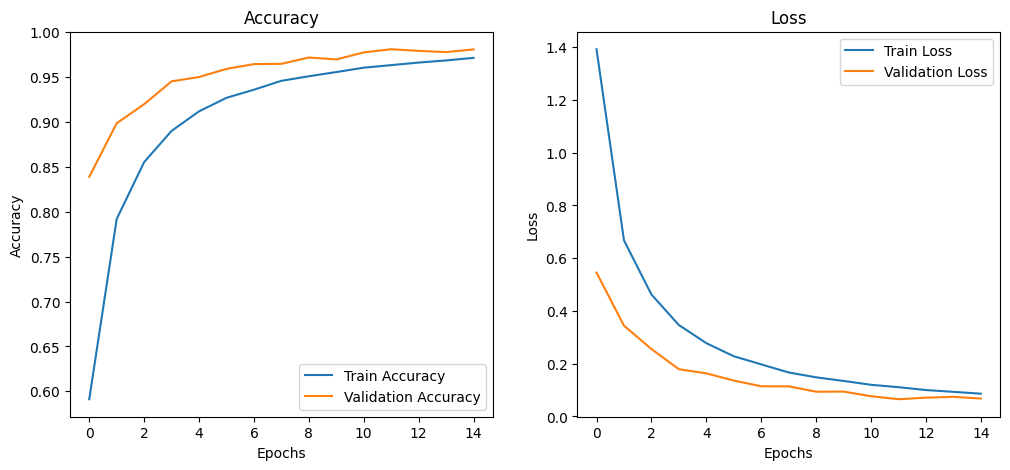

In [7]:
import matplotlib.pyplot as plt

def plot_training_history(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.show()

plot_training_history(train_acc, val_acc, train_loss, val_loss)


In [14]:
print("Training complete.")
print("Model saved as best_model.pt.")
print("Training Accuracy : " + str(max(train_acc) * 100) + "%")
print("Validation Accuracy : " + str(max(val_acc) * 100) + "%")

Training complete.
Model saved as best_model.pt.
Training Accuracy : 97.1370652251227%
Validation Accuracy : 98.10086065865282%
